In [1]:
from utils import check_dataset, load_files_from_json, find_task, create_basic_prompt, generate_coding_prompt, generate_prompt_with_image, generate_code_fixing_prompt, generate_continued_code_fixing_prompt
from llm_utils import generate_llm_response, initialize_client
from eval import extract_solution, evaluate_solution, fix_output_string, extract_code, execute_transform_function

import time
import json

import ast

import numpy as np
import pandas as pd

In [18]:
check_dataset()
train, eval = load_files_from_json()

config = {
    #'model': 'meta-llama/Llama-Vision-Free',
    #'model': 'pixtral-large-latest',
    # 'model': 'qwen/qwen2.5-vl-72b-instruct:free',
    #'model': 'google/gemma-3-27b-it:free',
    'model': 'codestral-latest',
    'solution_type': 'program_synthesis',
    #'temperatures': [0.1, 0.3, 0.5, 0.7, 0.9],
    'temperatures': [0.1, 0.3],
    'samples_per_step': 5,
    'code_correction_steps': 3
}

client = initialize_client('mistral')
print("Client initialized!")

#TODO: fix this
#file_path_initial_sampling = f"results/program_synthesis/{config['model']}_sampling.csv"
#file_path_code_fixing = f"results/program_synthesis/{config['model']}_code_fixing.csv"

# Load initial sampling results and create a subset of tasks where fixing the code might be successful
df = pd.read_csv("results/program_synthesis/codestral_full.csv")

solved_tasks = set(df.query("average_percentage_correct == 1.0")['task'].to_list())
relevant_tasks = set(df.query("average_percentage_correct > 0.8 and average_percentage_correct != 1 and task not in @solved_tasks")["task"].to_list())

attempt_fixing = (
    df
    .query("""task in @relevant_tasks and \
            average_percentage_correct != 1 and \
            (average_percentage_correct > 0.8 or \
            count_perfect_scores > 1)""")
    .drop_duplicates(subset=["average_percentage_correct"], keep='first')
    .sort_values(["count_perfect_scores", "average_percentage_correct"], ascending=False)
    .groupby("task")
    .head(3)
)

#Variables for final results

df_code_fix = pd.DataFrame()
df_info = pd.DataFrame()

#Run the code fixing for every entry in the dataframe that seems promising, max 3 per task
for index, (_, row) in enumerate(attempt_fixing.iterrows()):
    
    
    
    additional_infos = []
    task_id = row['task']
    task = train[task_id]
    answer = row['full_answer']
    generated_grids = ast.literal_eval(row['generated_grids'])

    messages = (generate_code_fixing_prompt(task=task, 
                                            extracted_answer=answer, 
                                            generated_inputs=generated_grids))
    
    for attempt_counter in range(0, config['code_correction_steps']):
        
        responses_list = []
        code_results = []
        additional_info = []

        
        print(f"Attempting to fix code for {row['task']}.")
        print(f"#{index} out of {attempt_fixing.shape[0]} -- Attempt #{attempt_counter+1} out of {config['code_correction_steps']}.")
        print("Generating code...")

        for temp in config['temperatures']:
            print(f"Generating {config['samples_per_step']} solutions using temperature {temp}")
            responses, additional_info = generate_llm_response(messages, 
                                                               client=client, 
                                                               model=config['model'],
                                                               num_samples=config['samples_per_step'], 
                                                               temperature=temp)
            #Ensure we dont exceed rate limits on API-services
            time.sleep(1.5)
            # Save the responses text to extract code and test its performance
            responses_list.extend(responses)
            # Save additional info for later data analysis
            additional_info.insert(0, task_id)
            additional_info.append(temp)
            additional_infos.append(additional_info)

        # From each response in the list, extract the python code and save to another list   
        generated_programs = []    
        for response in responses_list:
            extracted_code = extract_code(response)
            generated_programs.append(extracted_code)
        print(f"Saved {len(generated_programs)} from output.")
        

        for i, generated_code in enumerate(generated_programs):
            print(f"Attempting to run program #{i}...")
        
            generated_output_grids = []
            dicts_list = []
            # Set up individual input/output examples as arrays
            for example in task['train']:
                example_input = example['input']
                example_output = np.array(example['output'])
                # Then execute generated code for each example
                output_grid_with_llm_code = execute_transform_function(generated_code, example_input)
                generated_output_grids.append(output_grid_with_llm_code)
                try:
                    solution_array = np.array(output_grid_with_llm_code)
                except:
                    print("No numpy array could be made :(")
                # compare generated output to actual output
                result = evaluate_solution(solution_array, example_output)
                dicts_list.append(result)

            for d in dicts_list:
                print(d)
        
            # calculate performance indicators for each code generation
            percentage_correct_values = [d['percentage_correct'] for d in dicts_list]
            average_percentage_correct = sum(percentage_correct_values) / len(percentage_correct_values)
            count_perfect_scores = sum(1 for d in dicts_list if d['percentage_correct'] == 1.0)
            print(i, average_percentage_correct, count_perfect_scores)

            # save results:            
            row = (
            {
                'task': task_id,
                'sample_num': i+1,
                'full_answer': responses_list[i],
                'extracted_code': generated_code,
                'generated_grids': generated_output_grids,
                'average_percentage_correct': average_percentage_correct,
                'count_perfect_scores': count_perfect_scores,
                'num_attempt': attempt_counter
            })
            code_results.append(row)

        partial_df = pd.DataFrame(code_results)
        df_code_fix = pd.concat([df_code_fix, partial_df], ignore_index=True)
        
        # Save additional infos about compute etc.
        # df_info = pd.DataFrame(additional_infos,
        #                         columns=['task_name', 
        #                                  'processing_time', 
        #                                  'samples_drawn', 
        #                                  'input_tokens', 
        #                                  'output_tokens', 
        #                                  'temperature'])
        
        # Check if solution was found:
        #df_temp = pd.DataFrame(code_results)
        if (not partial_df.query("average_percentage_correct == 1").empty):
            print(f"Solution found after {attempt_counter} attempts!")
            break
        
        # Else determine best generated solution and start new code fixing attempt
        else:
            sorted_df = partial_df.sort_values(["count_perfect_scores", "average_percentage_correct"], ascending=False).head(1)
            result_dict = sorted_df.to_dict(orient='records')[0]
            
            # Generate new code fixing prompt
            updated_user_prompt = generate_continued_code_fixing_prompt(result_dict['generated_grids'])
            
            # Update "conversation" with LLM
            messages.append({"role": "assistant", "content": result_dict['full_answer']})
            messages.append({"role": "user", "content": updated_user_prompt})
            
            print("Starting new attempt...")
            attempt_counter += 1
    
    # Save results after every loop in case something breaks        
    df_code_fix.to_csv("results/program_synthesis/codestral_code_fixing_test2.csv", index=False)
    df_info.to_csv("results/program_synthesis/codestral_code_fixing_test_info2.csv", index=False)

ARC data complete.
Client initialized!
Attempting to fix code for aedd82e4.
#0 out of 128 -- Attempt #1 out of 3.
Generating code...
Generating 5 solutions using temperature 0.1
Time taken for 5 sample(s): 2.39 seconds
Generating 5 solutions using temperature 0.3
Time taken for 5 sample(s): 3.49 seconds
Saved 10 from output.
Attempting to run program #0...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
0 1.0 4
Attempting to run program #1...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.89}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.88}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.95}
{'answer_extracted': True, 'cor

KeyboardInterrupt: 

In [17]:


for i in range(attempt_counter, config['code_correction_steps']+1):
    print(attempt_counter)

1
1
1


In [29]:
df = pd.read_csv("results/codestral_baseline.csv")
df.shape
df.query("percentage_correct == 1").count()

task                    63
llm_full_answer         63
llm_extracted_answer    63
answer_extracted        63
correct_grid_size       63
percentage_correct      63
dtype: int64

In [24]:
df = pd.read_csv("results/program_synthesis/codestral_code_fixing_test.csv")
df.shape

(6400, 7)

In [3]:
filtered_df = df.query("task == 'aedd82e4'").sort_values(["count_perfect_scores", "average_percentage_correct"], ascending=False).head(1)
# Convert to a dictionary
result_dict = filtered_df.to_dict(orient='records')[0]
result_dict

updated_user_prompt = generate_continued_code_fixing_prompt(ast.literal_eval(result_dict['generated_grids']))
print(updated_user_prompt)

It seems like the answer is still not quite correct. The generated outputs now look like this:
    
Example 1: Generated Output:
[
[0, 2, 2],
[0, 2, 2],
[1, 0, 0]]

Example 2: Generated Output:
[
[2, 2, 2, 0],
[0, 2, 0, 0],
[0, 0, 0, 1],
[0, 1, 0, 0]]

Example 3: Generated Output:
[
[2, 2, 0, 0],
[0, 2, 0, 0],
[2, 2, 0, 1],
[0, 0, 0, 0],
[0, 2, 2, 2]]

Example 4: Generated Output:
[
[2, 2, 0],
[2, 0, 1],
[0, 1, 0]]


    
Please examine the output generated by the code you produced. Think about what went wrong. Consider that the problem may still either be in the initial hypothesis OR its implementation in code.
Reason carefully and for as long as necessary. Put that initial reasoning within <reasoning></reasoning> tags. Then correct the code accordingly. Make sure the corrected code you produce is still in a function named 'transform_grid()' and out all of the code within triple backticks (```python ```).


/tmp/ipykernel_5731/3550109862.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["bin"] = pd.cut(filtered_df["sample_num"], bins=bin_edges, right=True, labels=[f"{i}-{i+9}" for i in bin_edges[:-1]])


<Axes: xlabel='bin'>

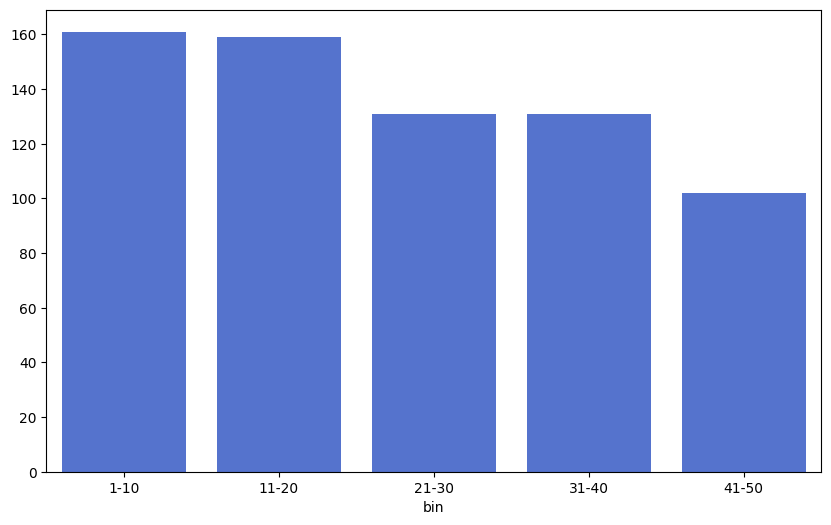

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df = (df
            .query("average_percentage_correct == 1")
            #.drop_duplicates(subset=["task"], keep='first')
    )

# Define bin edges (1-10, 11-20, ..., 41-50)
bin_edges = np.arange(1, 52, 10)  # Bins: [1-10, 11-20, ..., 41-50]

# Assign sample_num to bins
filtered_df["bin"] = pd.cut(filtered_df["sample_num"], bins=bin_edges, right=True, labels=[f"{i}-{i+9}" for i in bin_edges[:-1]])

# Count occurrences in each bin
bin_counts = filtered_df["bin"].value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, color="royalblue")

In [15]:
df.query("average_percentage_correct == 1")['task'].unique()

array(['aedd82e4', 'dc433765', '44f52bb0', 'd90796e8', 'dc1df850'],
      dtype=object)

In [25]:
df.groupby("task").agg({'average_percentage_correct':'max'})

,average_percentage_correct
task,
025d127b,0.955000
06df4c85,0.936667
08ed6ac7,0.805000
1f642eb9,0.953333
2204b7a8,0.996667
...,...
ef135b50,0.906667
f35d900a,0.802500
f76d97a5,0.666667


In [ ]:
df = pd.read_csv("results/llama-11b-vl_baseline.csv")
df.query("percentage_correct == 1")

task                    14
llm_full_answer         14
llm_extracted_answer    14
answer_extracted        14
correct_grid_size       14
percentage_correct      14
dtype: int64

In [24]:
attempt_fixing.groupby("task").agg({'average_percentage_correct':'max'})

,average_percentage_correct
task,
025d127b,0.815000
06df4c85,0.936667
08ed6ac7,0.805000
1f642eb9,0.913333
2204b7a8,0.980000
...,...
ef135b50,0.906667
f35d900a,0.802500
f76d97a5,0.666667


In [2]:
solved_tasks = set(df.query("average_percentage_correct == 1.0")['task'].to_list())
relevant_tasks = set(df.query("average_percentage_correct > 0.8 and average_percentage_correct != 1 and task not in @solved_tasks")["task"].to_list())

len(relevant_tasks)


197

In [ ]:
attempt_fixing = (
    df
    .query("""task in @relevant_tasks and \
            average_percentage_correct != 1 and \
            (average_percentage_correct > 0.8 or \
            count_perfect_scores > 1)""")
    .drop_duplicates(subset=["average_percentage_correct"], keep='first')
    .sort_values(["count_perfect_scores", "average_percentage_correct"], ascending=False)
    .groupby("task")
    .head(3)
)

attempt_fixing.shape

(128, 7)

In [ ]:
additional_infos = []
code_results = []

for index, row in attempt_fixing.iterrows():
    
    print(f"Attempting to fix code for {row['task']}.")
    print(f"#{index} out of {attempt_fixing.shape[0]}")
    
    print("Generating code...")
    responses_list = []
    additional_info = []

    task_id = row['task']
    task = train[task_id]
    answer = row['full_answer']
    generated_grids = ast.literal_eval(row['generated_grids'])
    
    messages = (generate_code_fixing_prompt(task=task, 
                                          extracted_answer=answer, 
                                          generated_inputs=generated_grids))
    
    for temp in config['temperatures']:
        print(f"Generating {config['samples_per_step']} solutions using temperature {temp}")
        responses, additional_info = generate_llm_response(messages, 
                                                           client=client, 
                                                           model=config['model'],
                                                           num_samples=config['samples_per_step'], 
                                                           temperature=temp)
        
        # Save the responses text to extract code and test its performance
        responses_list.extend(responses)
        
        # Save additional info for later data analysis
        additional_info.insert(0, task_id)
        additional_info.append(temp)
        additional_infos.append(additional_info)
        
    # From each response in the list, extract the python code and save to another list   
    generated_programs = []    
    for response in responses_list:
        extracted_code = extract_code(response)
        generated_programs.append(extracted_code)
        
    print(f"Saved {len(generated_programs)} from output.")
    
    generated_output_grids = []
        
    for i, generated_code in enumerate(generated_programs):
    
        print(f"Attempting to run program #{i}...")
        generated_output_grids = []
        dicts_list = []
        # Set up individual input/output examples as arrays
        for example in task['train']:
            example_input = example['input']
            example_output = np.array(example['output'])
            
            # Then execute generated code for each example
            output_grid_with_llm_code = execute_transform_function(generated_code, example_input)
            generated_output_grids.append(output_grid_with_llm_code)
            
            try:
                solution_array = np.array(output_grid_with_llm_code)
            except:
                print("No numpy array could be made :(")
            # compare generated output to actual output
            result = evaluate_solution(solution_array, example_output)
            dicts_list.append(result)
    
        for d in dicts_list:
            print(d)
        
        # calculate performance indicators for each code generation
        percentage_correct_values = [d['percentage_correct'] for d in dicts_list]
        average_percentage_correct = sum(percentage_correct_values) / len(percentage_correct_values)
        count_perfect_scores = sum(1 for d in dicts_list if d['percentage_correct'] == 1.0)
        
        print(i, average_percentage_correct, count_perfect_scores)
        # save results:            
        row = (
        {
            'task': task_id,
            'sample_num': i+1,
            'full_answer': responses_list[i],
            'extracted_code': generated_code,
            'generated_grids': generated_output_grids,
            'average_percentage_correct': average_percentage_correct,
            'count_perfect_scores': count_perfect_scores
        })
        
        code_results.append(row)
    
    # Save results after every loop in case something breaks    
    df_code_fix = pd.DataFrame(code_results)
    df_code_fix.to_csv("results/program_synthesis/codestral_code_fixing_test.csv", index=False)

    df_info = pd.DataFrame(additional_infos,
                       columns=['task_name', 'processing_time', 'samples_drawn', 'input_tokens', 'output_tokens', 'temperature'])
    df_info.to_csv("results/program_synthesis/codestral_code_fixing_test_info.csv", index=False)
    
    time.sleep(1.5)

Attempting to fix code for aedd82e4.
#11654 out of 128
Generating code...
Generating 5 solutions using temperature 0.1
Time taken for 5 sample(s): 2.38 seconds
Generating 5 solutions using temperature 0.3
Time taken for 5 sample(s): 2.78 seconds
Generating 5 solutions using temperature 0.5
Time taken for 5 sample(s): 2.26 seconds
Generating 5 solutions using temperature 0.7
Time taken for 5 sample(s): 2.80 seconds
Generating 5 solutions using temperature 0.9
Time taken for 5 sample(s): 2.70 seconds
Saved 25 from output.
Attempting to run program #0...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.89}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.88}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.95}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.78}
0 0.875 0
Attempting to run program #1...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correc

TypeError: cannot unpack non-iterable NoneType object

In [50]:
df_llama11b = pd.read_csv("results/llama-11b-vl_oneshot_reason.csv")
df_llama11b.query("percentage_correct == 1").count()

task                    13
llm_full_answer         13
llm_extracted_answer    13
answer_extracted        13
correct_grid_size       13
percentage_correct      13
dtype: int64

In [7]:
df_code_fix.query("average_percentage_correct == 1")

,task,sample_num,full_answer,extracted_code,generated_grids,average_percentage_correct,count_perfect_scores
0,aedd82e4,1,The reasoning provided by your colleague is co...,def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
1,aedd82e4,2,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
2,aedd82e4,3,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
3,aedd82e4,4,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
4,aedd82e4,5,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
5,aedd82e4,6,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
7,aedd82e4,8,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
8,aedd82e4,9,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
9,aedd82e4,10,"The initial reasoning is correct, but the impl...",def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
10,aedd82e4,11,The problem lies in the implementation of the ...,def transform_grid(grid):\n rows = len(grid...,"[[[0, 2, 2], [0, 2, 2], [1, 0, 0]], [[2, 2, 2,...",1.0,4
